In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')


In [14]:
# Load data
Path_Data = '3_merged_data3.txt'
df = pd.read_csv(Path_Data, sep='\t')

In [15]:
# Prepare data
X = df.drop(columns=['ID', 'avg7_calingiri'])
y = df['avg7_calingiri']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (119, 33048)
Shape of X_test: (30, 33048)


In [34]:
models = {
    #'LinearRegression': LinearRegression(),
    #'LassoRegression': Lasso(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(n_jobs=2),
    #'XGBoost': XGBRegressor(
      #  tree_method='gpu_hist',
       # predictor='gpu_predictor',
        #gpu_id=0,
        #n_jobs=-1,
        #random_state=42
    #),
    #'LGBMRegressor':LGBMRegressor(
    #    device='gpu',
    #    boosting_type='gbdt',
    #    n_jobs=5,
    #    random_state=42
    #),
    'GradientBoosting': GradientBoostingRegressor(),
}

k_values = [3, 5]

In [35]:
population_size = 20
mutation_rate = 0.1
num_generations = 10


def initialize_population():
    np.random.seed(42)
    population = []
    for _ in range(population_size):
        features = np.random.randint(2, size=X_train.shape[1])
        population.append(features)
    return population

def decode_individual(individual):
    return individual.astype(int)

def fitness_function(individual, model, kfold):
    features = decode_individual(individual)
    selected_cols = [i for i, bit in enumerate(features) if bit == 1]
    if len(selected_cols) == 0:
        return np.inf
    X_selected = X_train.iloc[:, selected_cols]
    scores = -1 * cross_val_score(model, X_selected, y_train, cv=kfold,
                                 scoring='neg_mean_squared_error', n_jobs=-1)
    return scores.mean()

def selection(population, scores):
    selected = []
    for _ in range(len(population)):
        i1, i2 = random.sample(range(len(population)), 2)
        selected.append(population[i1] if scores[i1] < scores[i2] else population[i2])
    return selected

def crossover(p1, p2):
    split_point = random.randint(1, len(p1) - 1)
    child1 = np.concatenate((p1[:split_point], p2[split_point:]))
    child2 = np.concatenate((p2[:split_point], p1[split_point:]))
    return child1, child2

def mutate(individual):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = 1 - individual[i]
    return individual



In [ ]:
import os
import joblib

# Create directory if not exists
save_dir = "saved_models_genetic"
os.makedirs(save_dir, exist_ok=True)

results = []

for model_name, model in models.items():
    for k in k_values:
        print(f"\nRunning GA for {model_name} with k={k} folds CV")
        kfold = KFold(n_splits=k, shuffle=True, random_state=42)
        population = initialize_population()

        for gen in tqdm(range(num_generations), desc=f"GA {model_name} k={k}"):
            scores = [fitness_function(ind, model, kfold) for ind in population]
            # Elitism: top 50%
            sorted_pop = [x for _, x in sorted(zip(scores, population), key=lambda pair: pair[0])]
            population = sorted_pop[:population_size//2]

            next_gen = population.copy()
            while len(next_gen) < population_size:
                p1, p2 = random.sample(population, 2)
                c1, c2 = crossover(p1, p2)
                next_gen.append(mutate(c1))
                if len(next_gen) < population_size:
                    next_gen.append(mutate(c2))
            population = next_gen

        best_individual = sorted(population, key=lambda ind: fitness_function(ind, model, kfold))[0]
        best_features = decode_individual(best_individual)
        selected_cols = [i for i, bit in enumerate(best_features) if bit == 1]

        if len(selected_cols) == 0:
            print("Warning: No features selected, skipping this configuration.")
            continue

        model.fit(X_train.iloc[:, selected_cols], y_train)
        y_pred = model.predict(X_test.iloc[:, selected_cols])

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        cv_mse = fitness_function(best_individual, model, kfold)

        results.append({
            'Model': model_name,
            'K_Folds': k,
            'CV_MSE': cv_mse,
            'Test_MSE': mse,
            'Test_MAE': mae,
            'Test_R2': r2,
            'Num_Features': len(selected_cols)
        })

        # Save the best model along with selected feature indices
        model_filename = f"{model_name}_k{k}_best_model.joblib"
        model_path = os.path.join(save_dir, model_filename)
        joblib.dump({
            'model': model,
            'selected_features': selected_cols
        }, model_path)

        print(f"Saved best model for {model_name} with k={k} at {model_path}")

summary_df = pd.DataFrame(results)
print("\nSummary:\n", summary_df)



Running GA for DecisionTree with k=3 folds CV


GA DecisionTree k=3: 100%|██████████| 10/10 [01:13<00:00,  7.37s/it]


Saved best model for DecisionTree with k=3 at saved_models_genetic\DecisionTree_k3_best_model.joblib

Running GA for DecisionTree with k=5 folds CV


GA DecisionTree k=5: 100%|██████████| 10/10 [01:23<00:00,  8.34s/it]


Saved best model for DecisionTree with k=5 at saved_models_genetic\DecisionTree_k5_best_model.joblib

Running GA for RandomForest with k=3 folds CV


GA RandomForest k=3: 100%|██████████| 10/10 [10:03<00:00, 60.39s/it]


Saved best model for RandomForest with k=3 at saved_models_genetic\RandomForest_k3_best_model.joblib

Running GA for RandomForest with k=5 folds CV


GA RandomForest k=5: 100%|██████████| 10/10 [16:21<00:00, 98.13s/it]


Saved best model for RandomForest with k=5 at saved_models_genetic\RandomForest_k5_best_model.joblib

Running GA for GradientBoosting with k=3 folds CV


GA GradientBoosting k=3: 100%|██████████| 10/10 [10:19<00:00, 61.93s/it]


Saved best model for GradientBoosting with k=3 at saved_models_genetic\GradientBoosting_k3_best_model.joblib

Running GA for GradientBoosting with k=5 folds CV


GA GradientBoosting k=5: 100%|██████████| 10/10 [13:12<00:00, 79.22s/it]


In [ ]:
import joblib
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Choose metric to pick best model
# For MSE lower is better, for R2 higher is better
metric = 'Test_MSE'  # or 'Test_R2'

# Find the best row based on metric
if metric == 'Test_MSE':
    best_idx = summary_df[metric].idxmin()
elif metric == 'Test_R2':
    best_idx = summary_df[metric].idxmax()
else:
    raise ValueError("Unsupported metric for selection")

best_model_info = summary_df.loc[best_idx]
model_name = best_model_info['Model']
k = best_model_info['K_Folds']

print(f"Best model by {metric}: {model_name} with k={k}")

# Build the path to the saved model file
model_filename = f"{model_name}_k{k}_best_model.joblib"
model_path = os.path.join("saved_models_genetic", model_filename)

# Load model and selected features
loaded_data = joblib.load(model_path)
loaded_model = loaded_data['model']
selected_features = loaded_data['selected_features']

print(f"Loaded model: {loaded_model}")
print(f"Selected features count: {len(selected_features)}")

# Run inference on test set with selected features
X_test_selected = X_test.iloc[:, selected_features]
y_pred = loaded_model.predict(X_test_selected)

# Calculate performance metrics on test set
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nPerformance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Show 10 predictions and their corresponding true values side-by-side
comparison_df = pd.DataFrame({
    'Predicted': y_pred[:10],
    'Actual': y_test.iloc[:10].values
})

print("\nSample Predictions vs Actual Values:")
print(comparison_df)


Best model by Test_MSE: LinearRegression with k=3
Loaded model: LinearRegression()
Selected features count: 16347

Performance on Test Set:
Mean Squared Error (MSE): 1.4538
Mean Absolute Error (MAE): 0.9957
R-squared (R2): -0.0552

Sample Predictions vs Actual Values:
   Predicted  Actual
0   5.178301    4.67
1   5.840579    5.00
2   3.335135    2.33
3   4.808837    3.33
4   2.997706    5.00
5   5.402685    6.00
6   4.433835    4.33
7   4.992523    3.33
8   4.627793    5.33
9   3.652309    6.83


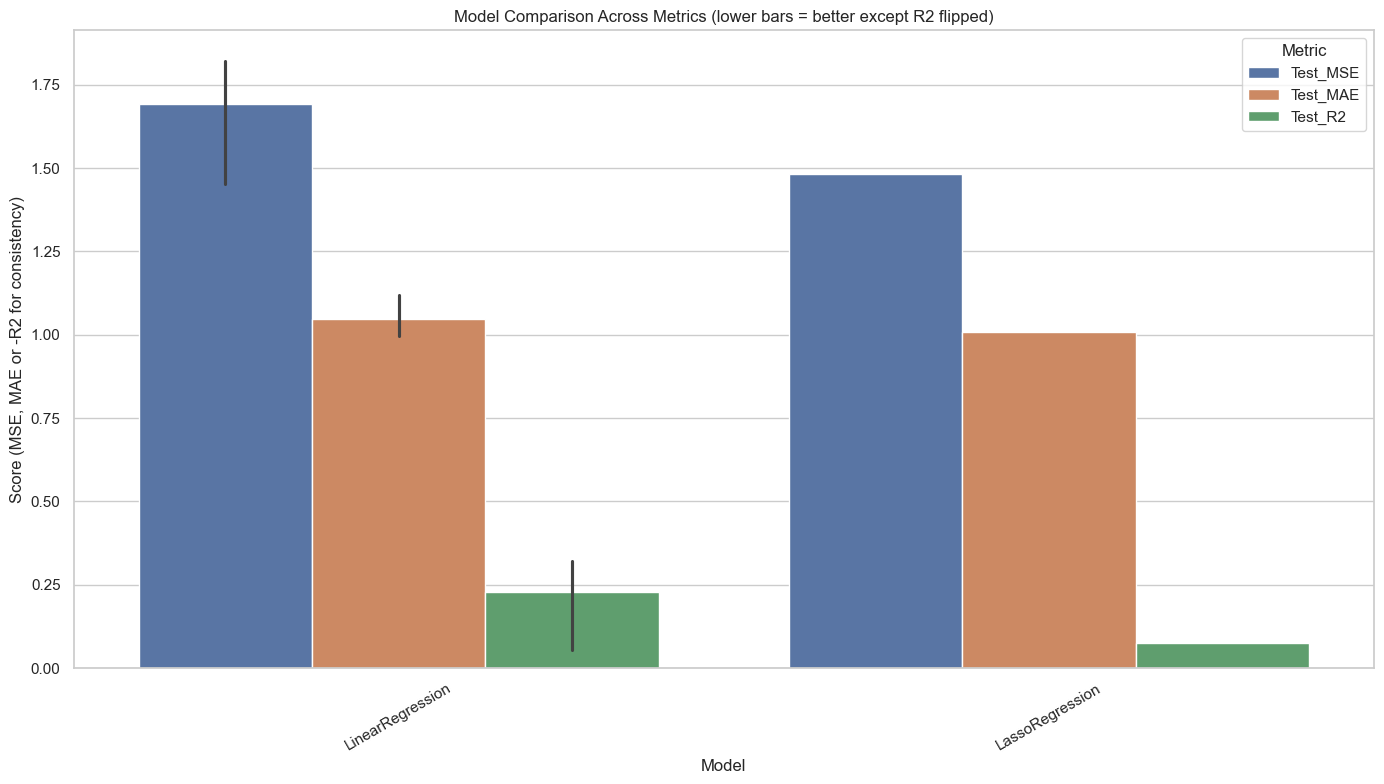

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better vibes
sns.set(style="whitegrid")

# Melt the dataframe to plot multiple metrics easily
metrics_df = summary_df.melt(
    id_vars=['Model', 'K_Folds'], 
    value_vars=['Test_MSE', 'Test_MAE', 'Test_R2'], 
    var_name='Metric', 
    value_name='Score'
)

# Flip R2 so it's easier to compare visually (higher is better)
# For R2, invert the scores to align with error metrics direction (optional)
metrics_df.loc[metrics_df['Metric'] == 'Test_R2', 'Score'] *= -1

plt.figure(figsize=(14, 8))
sns.barplot(data=metrics_df, x='Model', y='Score', hue='Metric')

plt.title("Model Comparison Across Metrics (lower bars = better except R2 flipped)")
plt.ylabel("Score (MSE, MAE or -R2 for consistency)")
plt.xlabel("Model")
plt.legend(title='Metric')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


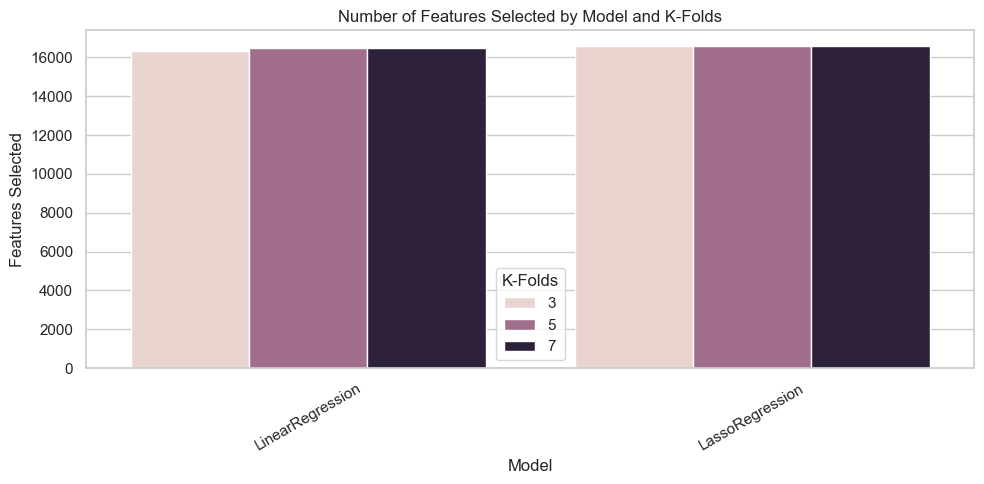

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=summary_df, x='Model', y='Num_Features', hue='K_Folds')
plt.title("Number of Features Selected by Model and K-Folds")
plt.ylabel("Features Selected")
plt.xlabel("Model")
plt.legend(title='K-Folds')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


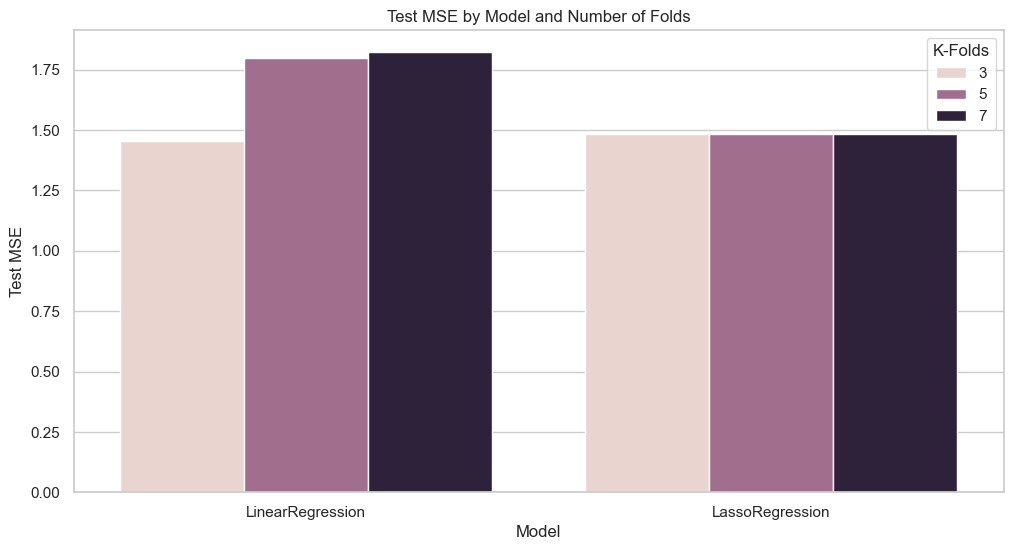

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style='whitegrid')

# 1. Barplot: Test MSE by Model and K-Folds
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x='Model', y='Test_MSE', hue='K_Folds')
plt.title('Test MSE by Model and Number of Folds')
plt.ylabel('Test MSE')
plt.xlabel('Model')
plt.legend(title='K-Folds')
plt.show()


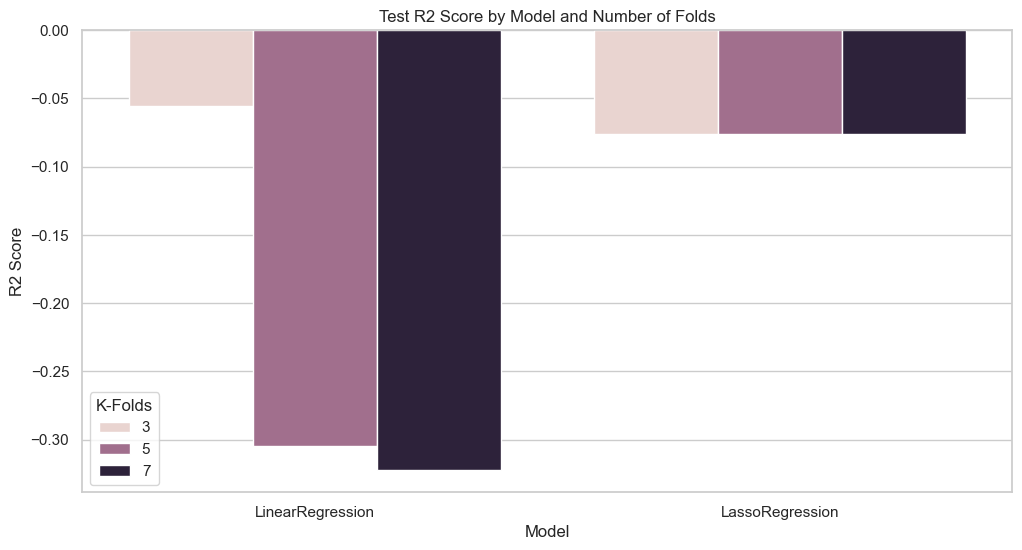

In [ ]:
# 2. Barplot: Test R2 by Model and K-Folds
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x='Model', y='Test_R2', hue='K_Folds')
plt.title('Test R2 Score by Model and Number of Folds')
plt.ylabel('R2 Score')
plt.xlabel('Model')
plt.legend(title='K-Folds')
plt.show()

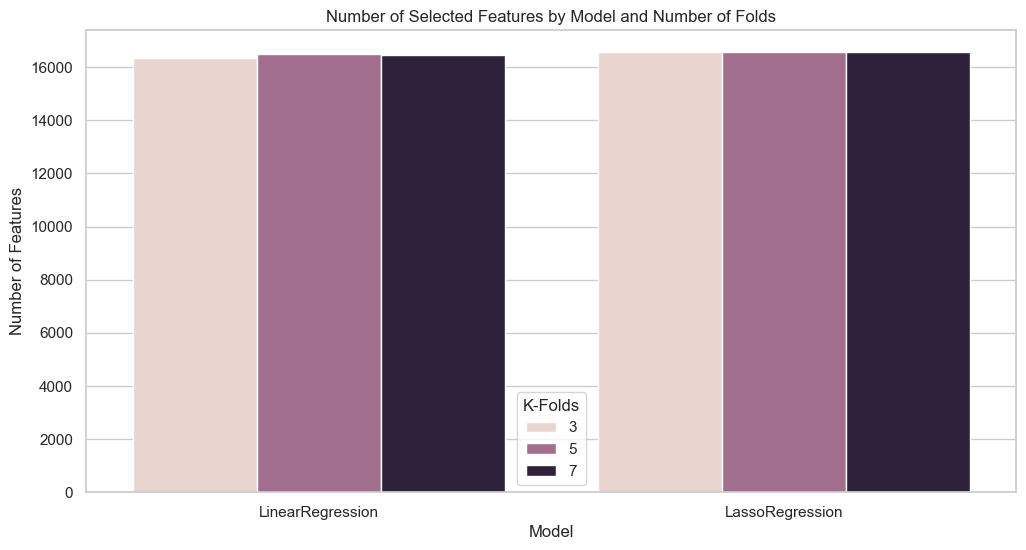

In [ ]:
# 3. Barplot: Number of Selected Features
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x='Model', y='Num_Features', hue='K_Folds')
plt.title('Number of Selected Features by Model and Number of Folds')
plt.ylabel('Number of Features')
plt.xlabel('Model')
plt.legend(title='K-Folds')
plt.show()


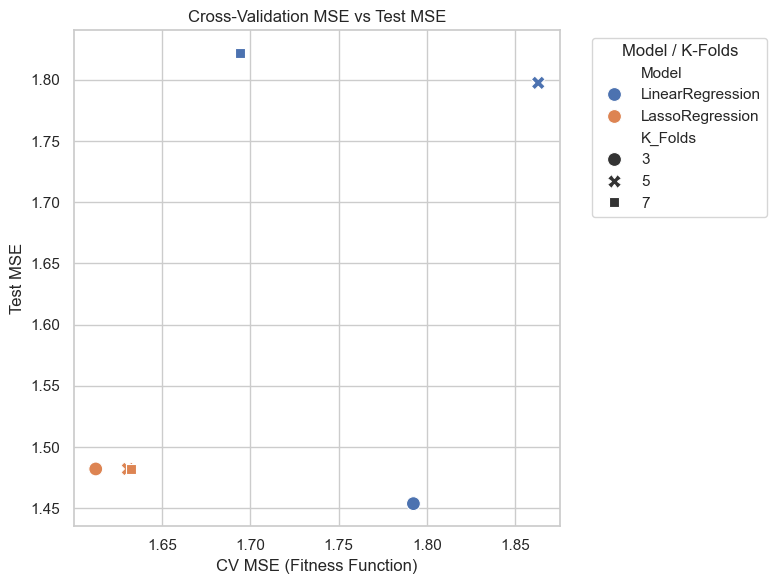

In [ ]:
# 4. Scatter: CV_MSE vs Test_MSE (to check correlation)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=summary_df, x='CV_MSE', y='Test_MSE', hue='Model', style='K_Folds', s=100)
plt.title('Cross-Validation MSE vs Test MSE')
plt.xlabel('CV MSE (Fitness Function)')
plt.ylabel('Test MSE')
plt.legend(title='Model / K-Folds', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Omer Code

In [ ]:
# --- GA Parameters ---
population_size = 50
mutation_rate = 0.1
num_generations = 10
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Initialize population (only feature bits now) ---
def initialize_population():
    np.random.seed(42)
    population = []
    for _ in range(population_size):
        features = np.random.randint(2, size=X_train.shape[1])
        population.append(features)
    return population

# --- Decode individual (only feature bits) ---
def decode_individual(individual):
    feature_bits = individual.astype(int)
    return feature_bits

# --- Fitness function ---
def fitness_function(individual):
    features = decode_individual(individual)
    selected_cols = [i for i, bit in enumerate(features) if bit == 1]
    if len(selected_cols) == 0:
        return np.inf

    model = LinearRegression()
    X_selected = X_train.iloc[:, selected_cols]
    scores = -1 * cross_val_score(model, X_selected, y_train, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
    return scores.mean()


In [ ]:
# --- Selection (Tournament) ---
def selection(population, scores):
    selected = []
    for _ in range(len(population)):
        i1, i2 = random.sample(range(len(population)), 2)
        selected.append(population[i1] if scores[i1] < scores[i2] else population[i2])
    return selected

# --- Crossover ---
def crossover(p1, p2):
    split_point = random.randint(1, len(p1) - 1)
    child1 = np.concatenate((p1[:split_point], p2[split_point:]))
    child2 = np.concatenate((p2[:split_point], p1[split_point:]))
    return child1, child2

# --- Mutation ---
def mutate(individual):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = 1 - individual[i]
    return individual


In [13]:
# --- Run GA ---
population = initialize_population()
history = []

for gen in tqdm(range(num_generations), desc="GA Generations"):
    scores = [fitness_function(ind) for ind in population]
    history.append(min(scores))

    # Elitism: top 50%
    sorted_pop = [x for _, x in sorted(zip(scores, population), key=lambda pair: pair[0])]
    population = sorted_pop[:population_size//2]

    next_gen = population.copy()
    while len(next_gen) < population_size:
        p1, p2 = random.sample(population, 2)
        c1, c2 = crossover(p1, p2)
        next_gen.append(mutate(c1))
        if len(next_gen) < population_size:
            next_gen.append(mutate(c2))

    population = next_gen

# --- Best individual ---
best_individual = sorted(population, key=fitness_function)[0]
best_features = decode_individual(best_individual)

print(f"\nSelected Features: {X.columns[best_features == 1].tolist()}")

GA Generations:  10%|█         | 1/10 [01:17<11:36, 77.34s/it]


KeyboardInterrupt: 

In [ ]:
# --- Train best model ---
lr_best = LinearRegression()
X_train_sel = X_train.iloc[:, best_features == 1]
X_test_sel = X_test.iloc[:, best_features == 1]

lr_best.fit(X_train_sel, y_train)
y_pred_test = lr_best.predict(X_test_sel)

mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("\n🔍 Final Evaluation on Test Set")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


🔍 Final Evaluation on Test Set
MSE: 1.5652
MAE: 1.0230
R2: -0.1361


In [18]:
# --- Save model and features ---
pickle.dump(lr_best, open("GA_LR_Model.pkl", "wb"))

selected_feature_indices = np.where(best_features == 1)[0]
selected_feature_names = X.columns[selected_feature_indices].tolist()

pickle.dump(selected_feature_indices, open("GA_Selected_Feature_Indices.pkl", "wb"))
pickle.dump(selected_feature_names, open("GA_Selected_Feature_Names.pkl", "wb"))

pd.Series(selected_feature_names, name="Selected_Features").to_csv("GA_Selected_Features.csv", index=False)

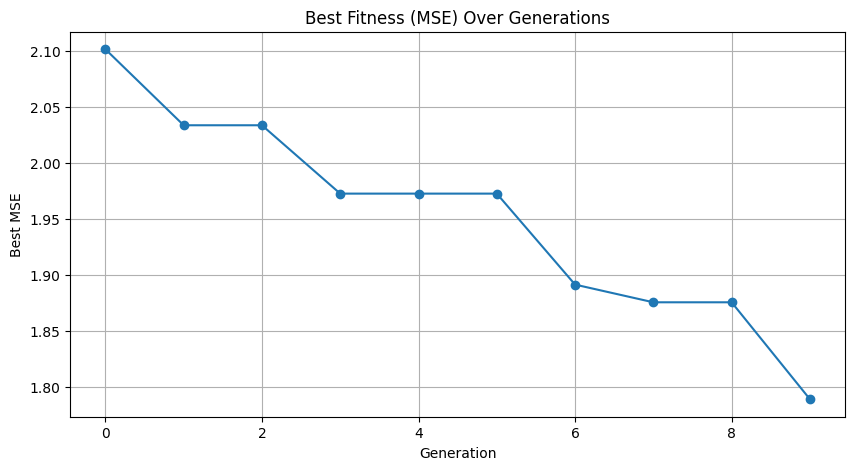

In [19]:
# --- Run All Experiments ---
for model_name, model in models.items():
    for k in k_values:
        run_ga_for_model(model_name, model, k)

In [20]:
# --- Train full model for comparison ---
model_full = LinearRegression()
model_full.fit(X_train, y_train)
y_pred_full = model_full.predict(X_test)

mse_full = mean_squared_error(y_test, y_pred_full)
mae_full = mean_absolute_error(y_test, y_pred_full)
r2_full = r2_score(y_test, y_pred_full)

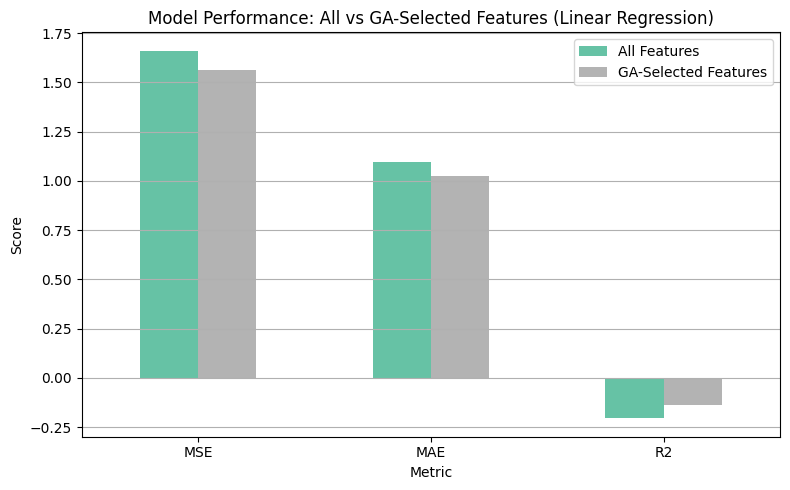

In [21]:
# --- Compare metrics visually ---
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R2'],
    'All Features': [mse_full, mae_full, r2_full],
    'GA-Selected Features': [mse, mae, r2]
})

metrics_df.set_index('Metric').plot(kind='bar', figsize=(8, 5), colormap='Set2')
plt.title("Model Performance: All vs GA-Selected Features (Linear Regression)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

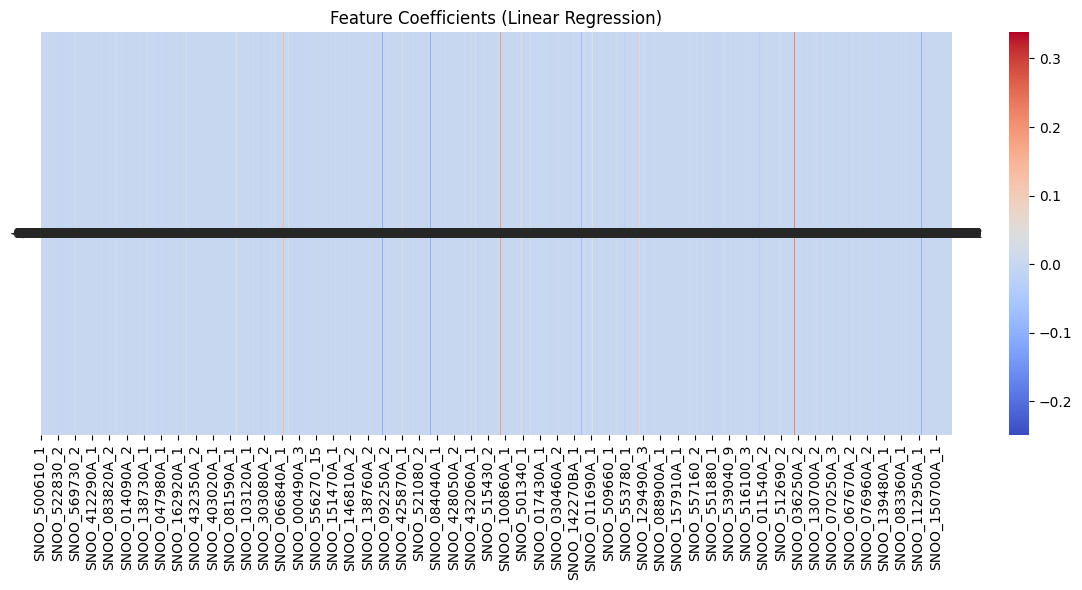

In [22]:
# --- Feature coefficients heatmap ---
plt.figure(figsize=(12, 6))
coefs = lr_best.coef_.reshape(1, -1)
sns.heatmap(pd.DataFrame(coefs, columns=X_train_sel.columns), cmap='coolwarm', annot=True)
plt.title("Feature Coefficients (Linear Regression)")
plt.tight_layout()
plt.show()